# 3D Uniaxial bar

The objective of this exercise is to implement a 3D finite element analysis (FEA) program using FEniCS. You are required to create a FEniCS code that performs the analysis, solve for the displacements and stresses in the bar, and visualize the results.


Materials:
- Steel material properties:
  - Young's Modulus (E): 200 GPa
  - Poisson's Ratio (ν): 0.3
  - Density (ρ): 7850 kg/m^3

Bar Dimensions:
- Length (Lx): 1 meter
- Ly and Lz: 0.02 meters (20 mm)

Boundary Conditions:
- One end of the bar is fixed (fixed boundary condition).
- The other end is subjected to a uniaxial tensile load:
  - Load (F): 10,000 N

Mesh:
- Use a simple 3D mesh for the bar, consisting of tetrahedral elements.


---
Steps:

1. Import FEniCS and Necessary Libraries
2. Define the Geometry and Mesh
3. Define the Material Properties
4. Define the Boundary Conditions
5. Define the Finite Element Function Space
6. Formulate the Governing Equations.
7.  Solve the System
8.  Calculate Stress
9.  Post-Processing and Visualization:

---

In [1]:
from dolfin import *

In [2]:
mesh =  BoxMesh(Point(0,0,0), Point(1,1,1),3,3,3)

In [199]:
mesh

In [3]:
from dolfin import *
from matplotlib import pyplot as plt

In [4]:
length, depth = 3, .300
num_ele_along_depth = 10
ele_size = depth/num_ele_along_depth
mesh = RectangleMesh(Point(0, 0), Point(length, depth),
                     int(length/ele_size), int(depth/ele_size))

In [5]:
V = FunctionSpace(mesh, 'CG', 1)
U = VectorFunctionSpace(mesh, 'CG', 1)
T0 = TensorFunctionSpace(mesh, 'DG', 0)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
dim = mesh.topology().dim()
dim

2

In [11]:
clamped_boundary = CompiledSubDomain("near(x[0],0)")
bc = DirichletBC(U, Constant((0,)*dim), clamped_boundary)

In [6]:
E, nu = 2e11, 0.3
rho, g = 7800, 9.81

In [7]:
lmbda = (E * nu) / ((1 + nu) * (1 - 2 * nu))
mu = E / (2 * (1 + nu))


def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)


def sigma(u):
    return lmbda*tr(epsilon(u))*Identity(dim) + 2*mu*epsilon(u)

In [8]:
f = Constant((0, -rho*g))
u = TrialFunction(U)
v = TestFunction(U)

In [14]:
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx

# Compute solution
u = Function(U)


In [ ]:
solve(a == L, u, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


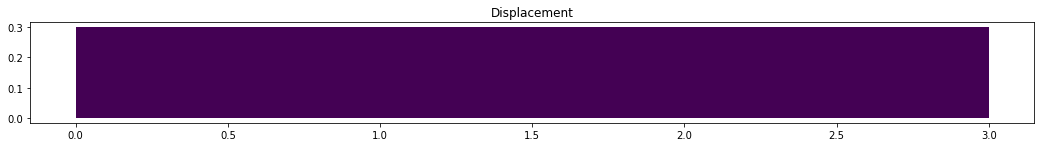

In [16]:
plt.figure(figsize=(18, 16))
# Plot solution
scale_factor = 1000
plot(u*scale_factor, title='Displacement', mode='displacement')